# Ensemble Learning

## Weighted Mean Ensemble

In [8]:
from models.ensemble_weighted_mean import EnsembleWeightedMean

ensemble_direct_optimization = EnsembleWeightedMean(optimization=True)
ensemble_direct_optimization_with_features = EnsembleWeightedMean(optimization=True, with_features=True)
ensemble_weigthed_mean = EnsembleWeightedMean(optimization=False)

data = 'ensemble-pd-hek293t-pe2.csv'

ensemble_direct_optimization.fit(data)
direct_optimization_performance = ensemble_direct_optimization.test(data) 

ensemble_weigthed_mean.fit(data)
weighted_mean_performance = ensemble_weigthed_mean.test(data)

ensemble_direct_optimization_with_features.fit(data)
with_features_performance = ensemble_direct_optimization_with_features.test(data)

/home/peiheng/development/ox-dissertation/models/ensemble_weighted_mean.py:189: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  predictions = torch.tensor(predictions, dtype=torch.float32).T


Pearson


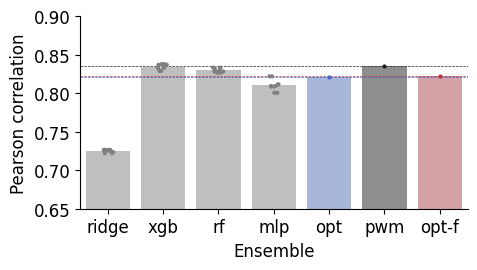

opt vs ridge t-statistic: 50.99729396868088, p-value: 2.1518343993309913e-12
Significant
opt vs xgb t-statistic: -3.8323470974082143, p-value: 0.004013271041194074
Significant
opt vs rf t-statistic: -3.1525394483462965, p-value: 0.011689682680398904
Significant
opt vs mlp t-statistic: 1.3651849964661502, p-value: 0.20534355879668034
Not significant
pwm vs ridge t-statistic: 58.700523723548926, p-value: 6.087774182245172e-13
Significant
pwm vs xgb t-statistic: 0.26187926127032024, p-value: 0.799309583419286
Not significant
pwm vs rf t-statistic: 1.9685221504522117, p-value: 0.08053332942055727
Not significant
pwm vs mlp t-statistic: 3.2730488675391607, p-value: 0.009635664290168334
Significant
opt-f vs ridge t-statistic: 51.60377227427601, p-value: 1.935277146736258e-12
Significant
opt-f vs xgb t-statistic: -3.510007047357765, p-value: 0.00661854919499981
Significant
opt-f vs rf t-statistic: -2.74935625634493, p-value: 0.022500495965001
Significant
opt-f vs mlp t-statistic: 1.5153918687

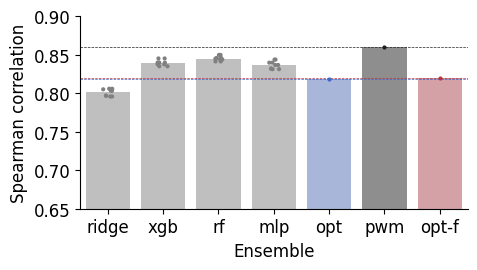

opt vs ridge t-statistic: 3.640872317212434, p-value: 0.005393561071320172
Significant
opt vs xgb t-statistic: -5.659031207664644, p-value: 0.0003100172966529837
Significant
opt vs rf t-statistic: -8.685354253009661, p-value: 1.141235973404293e-05
Significant
opt vs mlp t-statistic: -3.514841359746347, p-value: 0.006568457025129761
Significant
pwm vs ridge t-statistic: 12.548634642392162, p-value: 5.256732062787184e-07
Significant
pwm vs xgb t-statistic: 5.595443756422363, p-value: 0.00033622857436508316
Significant
pwm vs rf t-statistic: 4.932423983895909, p-value: 0.0008106344143909329
Significant
pwm vs mlp t-statistic: 4.543257096418127, p-value: 0.0013993741658809037
Significant
opt-f vs ridge t-statistic: 3.998330238113777, p-value: 0.0031182743072015215
Significant
opt-f vs xgb t-statistic: -5.20740249613887, p-value: 0.000558506924399768
Significant
opt-f vs rf t-statistic: -8.13888898842801, p-value: 1.9285946949590365e-05
Significant
opt-f vs mlp t-statistic: -3.1914794406236

In [9]:
import numpy as np
import pandas as pd
from os.path import join as pjoin

direct_op_pearson, direct_op_spearman = direct_optimization_performance
performance_weighted_pearson, performance_weighted_spearman = weighted_mean_performance
performance_with_features_pearson, performance_with_features_spearman = with_features_performance

# join the performance values, ignore the common keys
direct_op_pearson.update(performance_weighted_pearson)
direct_op_spearman.update(performance_weighted_spearman)

direct_op_pearson.update(performance_with_features_pearson)
direct_op_spearman.update(performance_with_features_spearman)

performance_pearson = direct_op_pearson
performance_spearman = direct_op_spearman

# plot the performance as bar plot
import matplotlib.pyplot as plt
import seaborn as sns

alpha = 0.5
f_size = 12
# plot the bar plot on top of the strip plot
# bar plot should be shortened to emphasize the difference in values
for name, performance in zip(['Pearson', 'Spearman'], [performance_pearson, performance_spearman]):
    # performance = pd.DataFrame({'Models': list(performance.keys()), 'Performance': list(performance.values()), 'Category': [0 if 'op' in model or 'pwm' in model else 1 for model in performance.keys()]})
    # print(performance)
    # add a category column
    print(name)
    fig, ax = plt.subplots(figsize=(5, 2.5))
    ax.set_ylim(0.65, 0.9)
    colour_palette = iter(sns.color_palette('icefire', n_colors=3))
    colours = ['gray' if not ('opt' in model or 'pwm' in model) else next(colour_palette) for model in performance.keys()]
    sns.stripplot(data=performance, ax=ax, alpha=1, jitter=0.1, size=3, palette=colours)
    sns.barplot(data=performance, ax=ax, alpha=alpha, palette=colours, errorbar=None)
    ax.set_xlabel('Ensemble', fontsize=f_size)
    ax.set_ylabel(f'{name} correlation', fontsize=f_size)
    ax.tick_params(axis='both', which='major', labelsize=f_size)
    ax.tick_params(axis='both', which='minor', labelsize=f_size)
    # remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # show a horizontal line at the mean for 'opt', 'pwm' models of matching color
    for ind, model in enumerate(performance.keys()):
        if 'opt' in model or 'pwm' in model:
            ax.axhline(y=performance[model], color=colours[ind], linestyle='--', linewidth=0.5)
    # rotate the x tick labels
    plt.show()
    
    # perform paired t-test between opt pwm models and the rest
    from scipy.stats import ttest_ind
    adaboost_values = {model: performance[model] for model in performance.keys() if 'opt' in model or 'pwm' in model}
    rest_values = {model: performance[model] for model in performance.keys() if not ('opt' in model or 'pwm' in model)}

    for ensemble, performance_ensemble in zip(adaboost_values.keys(), adaboost_values.values()):
        for rest, performance_rest in zip(rest_values.keys(), rest_values.values()):
            t_stat, p_value = ttest_ind(performance_ensemble, performance_rest)
            print(f'{ensemble} vs {rest} t-statistic: {t_stat}, p-value: {p_value}')
            if p_value < 0.05:
                print('Significant')
            else:
                print('Not significant')
                
    # save the figure
    fig.savefig(pjoin('dissertation', 'figures', f'ensemble_{name.lower()}.pdf'), bbox_inches='tight')

## Bagging



In [1]:
from models.ensemble_bagging import EnsembleBagging

data = 'ensemble-pd-hek293t-pe2.csv'

n_rounds = [1, 2, 3, 5, 10, 15]

performances_pearson = {}
performances_spearman = {}
for i in n_rounds:
    print(f'Bagging with {i} rounds')
    ensemble_bagging = EnsembleBagging(n_rounds=i)
    ensemble_bagging.fit(data)
    performance_pearson, performance_spearman = ensemble_bagging.test(data)
    performance_pearson[f'bag-{i}'] = performance_pearson.pop('bag')
    performance_spearman[f'bag-{i}'] = performance_spearman.pop('bag')
    performances_pearson.update(performance_pearson)
    performances_spearman.update(performance_spearman)

Bagging with 1 rounds
Bagging with 2 rounds
Bagging with 3 rounds
Bagging with 5 rounds
Bagging with 10 rounds
Bagging with 15 rounds


/tmp/ipykernel_63570/2497656310.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=20, horizontalalignment='right')


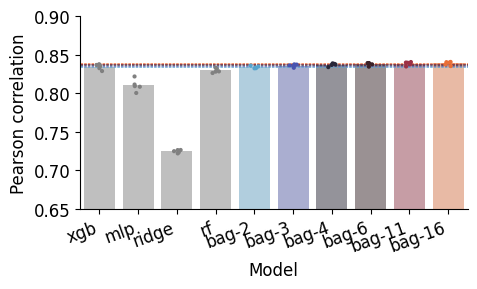

bag-2 vs xgb t-statistic: -0.2591303311231834, p-value: 0.8020778554699175
Not significant
bag-2 vs mlp t-statistic: 6.700567306346878, p-value: 0.00015261683058742434
Significant
bag-2 vs ridge t-statistic: 99.37267125070446, p-value: 1.1744004326571567e-13
Significant
bag-2 vs rf t-statistic: 2.879942574648604, p-value: 0.02051334605574235
Significant
bag-3 vs xgb t-statistic: 0.9268438785688546, p-value: 0.38111893368576966
Not significant
bag-3 vs mlp t-statistic: 7.257821370553002, p-value: 8.738726410735261e-05
Significant
bag-3 vs ridge t-statistic: 95.49989515484964, p-value: 1.6137045880579587e-13
Significant
bag-3 vs rf t-statistic: 4.182450492893656, p-value: 0.0030693042603817233
Significant
bag-4 vs xgb t-statistic: 1.5336752810997099, p-value: 0.1636525177639749
Not significant
bag-4 vs mlp t-statistic: 7.551508488975396, p-value: 6.598832851237692e-05
Significant
bag-4 vs ridge t-statistic: 93.85912938506993, p-value: 1.8534748418503093e-13
Significant
bag-4 vs rf t-stat

/tmp/ipykernel_63570/2497656310.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=20, horizontalalignment='right')


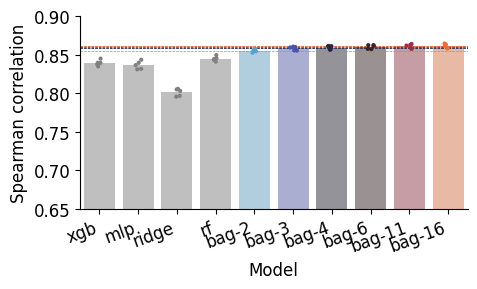

bag-2 vs xgb t-statistic: 8.524593967242835, p-value: 2.7567476363333754e-05
Significant
bag-2 vs mlp t-statistic: 7.557423077513316, p-value: 6.562187315323936e-05
Significant
bag-2 vs ridge t-statistic: 23.64494856740184, p-value: 1.0891688037509003e-08
Significant
bag-2 vs rf t-statistic: 6.398941173052546, p-value: 0.00020936881357383285
Significant
bag-3 vs xgb t-statistic: 9.433277145081814, p-value: 1.3098643000487233e-05
Significant
bag-3 vs mlp t-statistic: 8.387475335973042, p-value: 3.1018784433987344e-05
Significant
bag-3 vs ridge t-statistic: 23.853387623483755, p-value: 1.0162149498419609e-08
Significant
bag-3 vs rf t-statistic: 7.509647816689398, p-value: 6.864778490287218e-05
Significant
bag-4 vs xgb t-statistic: 10.047344182192232, p-value: 8.193983292011884e-06
Significant
bag-4 vs mlp t-statistic: 8.85875636327991, p-value: 2.081341188066927e-05
Significant
bag-4 vs ridge t-statistic: 24.386351754469846, p-value: 8.533930603447563e-09
Significant
bag-4 vs rf t-statis

In [2]:
import  numpy as np
import pandas as pd
from os.path import join as pjoin
from scipy.stats import ttest_ind

# plot the performance as bar plot
import matplotlib.pyplot as plt
import seaborn as sns

alpha = 0.5
f_size = 12

for name, performance in zip(['Pearson', 'Spearman'], [performances_pearson, performances_spearman]):
    fig, ax = plt.subplots(figsize=(5, 2.5))
    ax.set_ylim(0.65, 0.9)
    colour_palette = iter(sns.color_palette('icefire', n_colors=len(n_rounds)))
    colours = ['gray' if 'bag' not in model else next(colour_palette) for model in performance.keys()]
    sns.stripplot(data=performance, ax=ax, alpha=1, jitter=0.1, size=3, palette=colours)
    sns.barplot(data=performance, ax=ax, alpha=alpha, palette=colours, errorbar=None)
    ax.set_xlabel('Model', fontsize=f_size)
    ax.set_ylabel(f'{name} correlation', fontsize=f_size)
    ax.tick_params(axis='both', which='major', labelsize=f_size)
    ax.tick_params(axis='both', which='minor', labelsize=f_size)
    # remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # show a horizontal line at the mean for adaboost model
    for ind, model in enumerate(performance.keys()):
        if 'bag' in model:
            ax.axhline(y=np.mean(performance[model]), color=colours[ind], linestyle='--', linewidth=0.5)
    # rotate the x tick labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=20, horizontalalignment='right')
    plt.show()
    
    # perform paired t-test between opt pwm models and the rest
    from scipy.stats import ttest_ind
    adaboost_values = {model: performance[model] for model in performance.keys() if 'bag' in model}
    rest_values = {model: performance[model] for model in performance.keys() if 'bag' not in model}

    for ensemble, performance_ensemble in zip(adaboost_values.keys(), adaboost_values.values()):
        for rest, performance_rest in zip(rest_values.keys(), rest_values.values()):
            t_stat, p_value = ttest_ind(performance_ensemble, performance_rest)
            print(f'{ensemble} vs {rest} t-statistic: {t_stat}, p-value: {p_value}')
            if p_value < 0.05:
                print('Significant')
            else:
                print('Not significant')

In [1]:
from models.ensemble_bagging import EnsembleBagging

data = 'ensemble-pd-hek293t-pe2.csv'

percentages = [0.3, 0.5, 0.7, 0.9]

performances_pearson = {}
performances_spearman = {}
for i in percentages:
    ensemble_bagging = EnsembleBagging(n_rounds=3, sample_percentage=i)
    ensemble_bagging.fit(data)
    performance_pearson, performance_spearman = ensemble_bagging.test(data)
    performance_pearson[f'bag-{i}'] = performance_pearson.pop('bag')
    performance_spearman[f'bag-{i}'] = performance_spearman.pop('bag')
    performances_pearson.update(performance_pearson)
    performances_spearman.update(performance_spearman)

Training xgb
Training mlp
  epoch    train_loss    valid_loss    cp      lr     dur
-------  ------------  ------------  ----  ------  ------
      1     1384.3451      879.8785     +  0.0050  0.1197
      2      840.9931      851.8398     +  0.0049  0.0381
      3      765.4059      776.0560     +  0.0045  0.0339
      4      762.2152      766.2096     +  0.0040  0.0313
      5      730.2833      727.9403     +  0.0033  0.0326
      6      702.1952      719.5201     +  0.0025  0.0273
      7      689.3989      701.5451     +  0.0017  0.0273
      8      677.3168      693.2712     +  0.0010  0.0279
      9      673.0590      689.8685     +  0.0005  0.1108
     10      670.9880      688.8520     +  0.0001  0.0291
     11      656.9929      643.7928     +  0.0050  0.0280
     12      615.1592      598.3959     +  0.0049  0.0276
     13      576.9904      558.4728     +  0.0045  0.0274
     14      545.1558      530.2461     +  0.0040  0.0299
     15      522.9449      512.6600     +  0.0

/tmp/ipykernel_65955/2162010592.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=20, horizontalalignment='right')


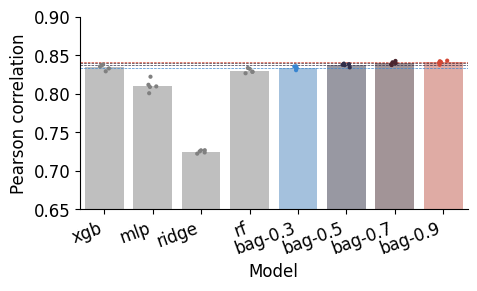

/tmp/ipykernel_65955/2162010592.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=20, horizontalalignment='right')


bag-0.3 vs xgb t-statistic: -0.29792470730428255, p-value: 0.7733512357643972
Not significant
bag-0.3 vs mlp t-statistic: 6.564951371440881, p-value: 0.00017570165943656718
Significant
bag-0.3 vs ridge t-statistic: 85.94187801856273, p-value: 3.7487525694169995e-13
Significant
bag-0.3 vs rf t-statistic: 2.5762410629819046, p-value: 0.0328075434628099
Significant
bag-0.5 vs xgb t-statistic: 1.5336752810997099, p-value: 0.1636525177639749
Not significant
bag-0.5 vs mlp t-statistic: 7.551508488975396, p-value: 6.598832851237692e-05
Significant
bag-0.5 vs ridge t-statistic: 93.85912938506993, p-value: 1.8534748418503093e-13
Significant
bag-0.5 vs rf t-statistic: 4.843382355315982, p-value: 0.0012825993780931182
Significant
bag-0.7 vs xgb t-statistic: 2.744370968078686, p-value: 0.025277866761869713
Significant
bag-0.7 vs mlp t-statistic: 8.147082499067581, p-value: 3.82921093313729e-05
Significant
bag-0.7 vs ridge t-statistic: 89.5560072308362, p-value: 2.697127629772452e-13
Significant
ba

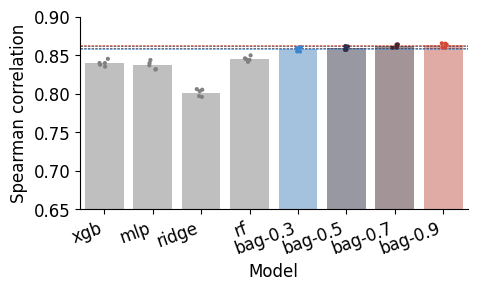

bag-0.3 vs xgb t-statistic: 8.837002831141405, p-value: 2.1191974346715402e-05
Significant
bag-0.3 vs mlp t-statistic: 7.966110614125454, p-value: 4.502271164763015e-05
Significant
bag-0.3 vs ridge t-statistic: 23.172637137078066, p-value: 1.277292217274518e-08
Significant
bag-0.3 vs rf t-statistic: 6.858551979527778, p-value: 0.00012985843658161773
Significant
bag-0.5 vs xgb t-statistic: 10.047344182192232, p-value: 8.193983292011884e-06
Significant
bag-0.5 vs mlp t-statistic: 8.85875636327991, p-value: 2.081341188066927e-05
Significant
bag-0.5 vs ridge t-statistic: 24.386351754469846, p-value: 8.533930603447563e-09
Significant
bag-0.5 vs rf t-statistic: 8.203892983753496, p-value: 3.64161084497051e-05
Significant
bag-0.7 vs xgb t-statistic: 11.536667887345045, p-value: 2.8924804844553507e-06
Significant
bag-0.7 vs mlp t-statistic: 9.888869282563473, p-value: 9.226196885818248e-06
Significant
bag-0.7 vs ridge t-statistic: 25.982207415466103, p-value: 5.168790560651378e-09
Significant


In [3]:
import  numpy as np
import pandas as pd
from os.path import join as pjoin
from scipy.stats import ttest_ind

# plot the performance as bar plot
import matplotlib.pyplot as plt
import seaborn as sns

alpha = 0.5
f_size = 12

for name, performance in zip(['Pearson', 'Spearman'], [performances_pearson, performances_spearman]):
    fig, ax = plt.subplots(figsize=(5, 2.5))
    ax.set_ylim(0.65, 0.9)
    colour_palette = iter(sns.color_palette('icefire', n_colors=len(percentages)))
    colours = ['gray' if 'bag' not in model else next(colour_palette) for model in performance.keys()]
    sns.stripplot(data=performance, ax=ax, alpha=1, jitter=0.1, size=3, palette=colours)
    sns.barplot(data=performance, ax=ax, alpha=alpha, palette=colours, errorbar=None)
    ax.set_xlabel('Model', fontsize=f_size)
    ax.set_ylabel(f'{name} correlation', fontsize=f_size)
    ax.tick_params(axis='both', which='major', labelsize=f_size)
    ax.tick_params(axis='both', which='minor', labelsize=f_size)
    # remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # show a horizontal line at the mean for adaboost model
    for ind, model in enumerate(performance.keys()):
        if 'bag' in model:
            ax.axhline(y=np.mean(performance[model]), color=colours[ind], linestyle='--', linewidth=0.5)
    # rotate the x tick labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=20, horizontalalignment='right')
    plt.show()
    
    # perform paired t-test between opt pwm models and the rest
    from scipy.stats import ttest_ind
    adaboost_values = {model: performance[model] for model in performance.keys() if 'bag' in model}
    rest_values = {model: performance[model] for model in performance.keys() if 'bag' not in model}

    for ensemble, performance_ensemble in zip(adaboost_values.keys(), adaboost_values.values()):
        for rest, performance_rest in zip(rest_values.keys(), rest_values.values()):
            t_stat, p_value = ttest_ind(performance_ensemble, performance_rest)
            print(f'{ensemble} vs {rest} t-statistic: {t_stat}, p-value: {p_value}')
            if p_value < 0.05:
                print('Significant')
            else:
                print('Not significant')

## AdaBoost Ensemble

In [10]:
from models.ensemble_adaboost import EnsembleAdaBoost

data = 'ensemble-pd-hek293t-pe2.csv'

ensemble_adaboost_performances_pearson = {}
ensemble_adaboost_performances_spearman = {}

rounds = 3

for round in range(rounds):  
    ensemble_adaboost = EnsembleAdaBoost(n_rounds=round+1)
    ensemble_adaboost.fit(data)
    ensemble_adaboost_performance_pearson, ensemble_adaboost_performance_spearman = ensemble_adaboost.test(data)
    # rename the keys to include the round number
    ensemble_adaboost_performance_pearson[f'ada-{round+1}'] = ensemble_adaboost_performance_pearson.pop('ada')
    ensemble_adaboost_performance_spearman[f'ada-{round+1}'] = ensemble_adaboost_performance_spearman.pop('ada')

    ensemble_adaboost_performances_pearson.update(ensemble_adaboost_performance_pearson)
    ensemble_adaboost_performances_spearman.update(ensemble_adaboost_performance_spearman)

Round 1 xgb 0.9287071577778316


/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Round 1 mlp 0.7289590529087824
Round 1 ridge 0.6861002018427683
Round 1 rf 0.8821179025143826
Round 1 xgb 0.9301076653782875


/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Round 1 mlp 0.7276758035066124
Round 1 ridge 0.6792598992423717
Round 1 rf 0.88062332471248
Round 1 xgb 0.9316336484556391


/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Round 1 mlp 0.7327430458353404
Round 1 ridge 0.6823366191230589
Round 1 rf 0.8799330106429073
Round 1 xgb 0.9307239967282566


/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Round 1 mlp 0.7407019711876114
Round 1 ridge 0.6891353982929959
Round 1 rf 0.8778893645492821
Round 1 xgb 0.9281359644548639


/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Round 1 mlp 0.734398862260017
Round 1 ridge 0.6735094994141857
Round 1 rf 0.8784489505029378


/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: siz

Round 1 xgb 0.9287071577778316


/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Round 1 mlp 0.7289590529087824
Round 1 ridge 0.6861002018427683
Round 1 rf 0.8821179025143826
Round 2 xgb 0.8828891822773463


/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Round 2 mlp 0.7357810441910475
Round 2 ridge 0.6394083709187866
Round 2 rf 0.8861714729298973
Round 1 xgb 0.9301076653782875


/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Round 1 mlp 0.7276758035066124
Round 1 ridge 0.6792598992423717
Round 1 rf 0.88062332471248
Round 2 xgb 0.884664028211948


/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Round 2 mlp 0.7390281404588601
Round 2 ridge 0.6716487840230975
Round 2 rf 0.8842833530681941
Round 1 xgb 0.9316336484556391


/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Round 1 mlp 0.7327430458353404
Round 1 ridge 0.6823366191230589
Round 1 rf 0.8799330106429073
Round 2 xgb 0.883017885554937


/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Round 2 mlp 0.7371320687631029
Round 2 ridge 0.6150833962202543
Round 2 rf 0.8826804461079631
Round 1 xgb 0.9307239967282566


/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Round 1 mlp 0.7407019711876114
Round 1 ridge 0.6891353982929959
Round 1 rf 0.8778893645492821
Round 2 xgb 0.884817470488282


/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Round 2 mlp 0.7444712413260282
Round 2 ridge 0.6457313874885726
Round 2 rf 0.8840324690103845
Round 1 xgb 0.9281359644548639


/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Round 1 mlp 0.734398862260017
Round 1 ridge 0.6735094994141857
Round 1 rf 0.8784489505029378
Round 2 xgb 0.8831450365065034


/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Round 2 mlp 0.7289656746005047
Round 2 ridge 0.6359158373801382
Round 2 rf 0.8803509654616453


/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: siz

Round 1 xgb 0.9287071577778316


/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Round 1 mlp 0.7289590529087824
Round 1 ridge 0.6861002018427683
Round 1 rf 0.8821179025143826
Round 2 xgb 0.8828891822773463


/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Round 2 mlp 0.7357810441910475
Round 2 ridge 0.6394083709187866
Round 2 rf 0.8861714729298973
Round 3 xgb 0.8691946771726528


/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Round 3 mlp 0.7311318623814502
Round 3 ridge 0.6477974798630257
Round 3 rf 0.8884662016102609
Round 1 xgb 0.9301076653782875


/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Round 1 mlp 0.7276758035066124
Round 1 ridge 0.6792598992423717
Round 1 rf 0.88062332471248
Round 2 xgb 0.884664028211948


/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Round 2 mlp 0.7390281404588601
Round 2 ridge 0.6716487840230975
Round 2 rf 0.8842833530681941
Round 3 xgb 0.872945297783664


/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Round 3 mlp 0.7211722488586303
Round 3 ridge 0.6474865890652441
Round 3 rf 0.8890347469228945
Round 1 xgb 0.9316336484556391


/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Round 1 mlp 0.7327430458353404
Round 1 ridge 0.6823366191230589
Round 1 rf 0.8799330106429073
Round 2 xgb 0.883017885554937


/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Round 2 mlp 0.7371320687631029
Round 2 ridge 0.6150833962202543
Round 2 rf 0.8826804461079631
Round 3 xgb 0.8731509998404214


/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Round 3 mlp 0.7402072737724883
Round 3 ridge 0.631353796932459
Round 3 rf 0.8910286168576799
Round 1 xgb 0.9307239967282566


/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Round 1 mlp 0.7407019711876114
Round 1 ridge 0.6891353982929959
Round 1 rf 0.8778893645492821
Round 2 xgb 0.884817470488282


/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Round 2 mlp 0.7444712413260282
Round 2 ridge 0.6457313874885726
Round 2 rf 0.8840324690103845
Round 3 xgb 0.8728981523691286


/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Round 3 mlp 0.7267650698866089
Round 3 ridge 0.6540661284893433
Round 3 rf 0.8884702474913796
Round 1 xgb 0.9281359644548639


/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Round 1 mlp 0.734398862260017
Round 1 ridge 0.6735094994141857
Round 1 rf 0.8784489505029378
Round 2 xgb 0.8831450365065034


/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Round 2 mlp 0.7289656746005047
Round 2 ridge 0.6359158373801382
Round 2 rf 0.8803509654616453
Round 3 xgb 0.8729840156215191


/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Round 3 mlp 0.731522762448535
Round 3 ridge 0.6102483646782708
Round 3 rf 0.8871573098623424


/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/home/peiheng/anaconda3/envs/dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: siz

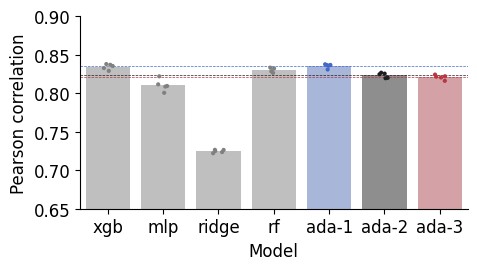

ada-1 vs xgb t-statistic: 0.5410354127930009, p-value: 0.603218069208251
Not significant
ada-1 vs mlp t-statistic: 6.870307641475497, p-value: 0.00012832151033550176
Significant
ada-1 vs ridge t-statistic: 74.8227310670726, p-value: 1.1342714620355011e-12
Significant
ada-1 vs rf t-statistic: 3.2545222600733683, p-value: 0.011622147874524912
Significant
ada-2 vs xgb t-statistic: -5.125057822302056, p-value: 0.0009015555054270796
Significant
ada-2 vs mlp t-statistic: 3.4294866556859667, p-value: 0.008961626759264908
Significant
ada-2 vs ridge t-statistic: 58.03769313008191, p-value: 8.626367324122345e-12
Significant
ada-2 vs rf t-statistic: -3.3304429444256174, p-value: 0.01037756518563209
Significant
ada-3 vs xgb t-statistic: -6.477149834337102, p-value: 0.00019269472215042635
Significant
ada-3 vs mlp t-statistic: 2.8310604600299647, p-value: 0.022114085846608143
Significant
ada-3 vs ridge t-statistic: 60.64877690753744, p-value: 6.070785062894418e-12
Significant
ada-3 vs rf t-statistic

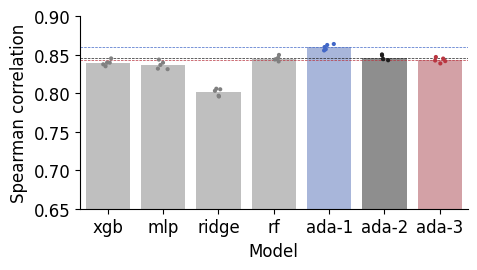

ada-1 vs xgb t-statistic: 8.857777850969486, p-value: 2.0830277593559523e-05
Significant
ada-1 vs mlp t-statistic: 8.206540485845347, p-value: 3.6331209321143726e-05
Significant
ada-1 vs ridge t-statistic: 22.121367519117637, p-value: 1.842323818540579e-08
Significant
ada-1 vs rf t-statistic: 7.02960012109287, p-value: 0.0001093644865292297
Significant
ada-2 vs xgb t-statistic: 3.0203474356875177, p-value: 0.016550726541205072
Significant
ada-2 vs mlp t-statistic: 3.4417512241007286, p-value: 0.00880106926327951
Significant
ada-2 vs ridge t-statistic: 17.344638616858145, p-value: 1.2440958310077713e-07
Significant
ada-2 vs rf t-statistic: 0.5507518474663192, p-value: 0.5968437556843471
Not significant
ada-3 vs xgb t-statistic: 1.6121005455778283, p-value: 0.14560511842286236
Not significant
ada-3 vs mlp t-statistic: 2.30824824669992, p-value: 0.049825148937469095
Significant
ada-3 vs ridge t-statistic: 16.28311418354004, p-value: 2.0362471965241952e-07
Significant
ada-3 vs rf t-statist

In [11]:
import  numpy as np
import pandas as pd
from os.path import join as pjoin
from scipy.stats import ttest_ind
# plot the performance as bar plot
import matplotlib.pyplot as plt
import seaborn as sns

alpha = 0.5
f_size = 12

for name, performance in zip(['Pearson', 'Spearman'], [ensemble_adaboost_performances_pearson, ensemble_adaboost_performances_spearman]):
    fig, ax = plt.subplots(figsize=(5, 2.5))
    ax.set_ylim(0.65, 0.9)
    colour_palette = iter(sns.color_palette('icefire', n_colors=rounds))
    colours = ['gray' if 'ada' not in model else next(colour_palette) for model in performance.keys()]
    sns.stripplot(data=performance, ax=ax, alpha=1, jitter=0.1, size=3, palette=colours)
    sns.barplot(data=performance, ax=ax, alpha=alpha, palette=colours, errorbar=None)
    ax.set_xlabel('Model', fontsize=f_size)
    ax.set_ylabel(f'{name} correlation', fontsize=f_size)
    ax.tick_params(axis='both', which='major', labelsize=f_size)
    ax.tick_params(axis='both', which='minor', labelsize=f_size)
    # remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # show a horizontal line at the mean for adaboost model
    for ind, model in enumerate(performance.keys()):
        if 'ada' in model:
            ax.axhline(y=np.mean(performance[model]), color=colours[ind], linestyle='--', linewidth=0.5)
    # rotate the x tick labels
    plt.show()
    
    # perform paired t-test between opt pwm models and the rest
    from scipy.stats import ttest_ind
    adaboost_values = {model: performance[model] for model in performance.keys() if 'ada' in model}
    rest_values = {model: performance[model] for model in performance.keys() if 'ada' not in model}

    for ensemble, performance_ensemble in zip(adaboost_values.keys(), adaboost_values.values()):
        for rest, performance_rest in zip(rest_values.keys(), rest_values.values()):
            t_stat, p_value = ttest_ind(performance_ensemble, performance_rest)
            print(f'{ensemble} vs {rest} t-statistic: {t_stat}, p-value: {p_value}')
            if p_value < 0.05:
                print('Significant')
            else:
                print('Not significant')